In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse import coo_matrix, csr_matrix, diags, issparse
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, adjusted_rand_score
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors

In [ ]:
# Load the data
circles = pd.read_csv('Circle.csv', header=None, names=['x', 'y'])
spirals = pd.read_csv('Spiral.csv', header=None, names=['x', 'y', 'label'])

In [ ]:
len(circles), len(spirals)

(900, 312)

# Circle dataset

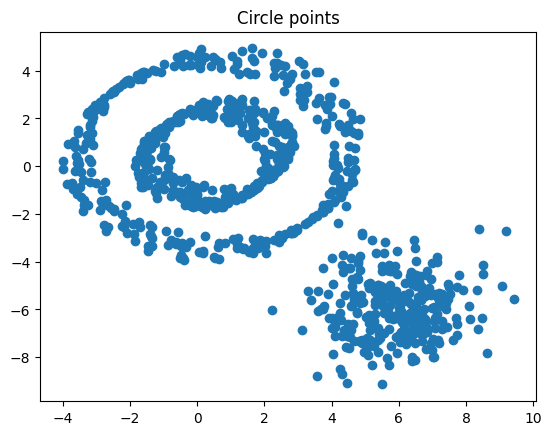

In [ ]:
plt.scatter(circles.loc[:, 'x'], circles.loc[:, 'y'])
plt.title('Circle points')
plt.show()

In [ ]:
# Define function to compute similarity between two points
def compute_similarity(x_i, x_j):
  sigma=1
  return np.exp(-np.linalg.norm(x_i-x_j)/2*sigma**2)

# Define function to compute similarity matrix
def compute_similarity_matrix(X):
  n = X.shape[0]
  S = np.zeros((n, n))
  for i in range(n):
    for j in range(i):
      S[i, j] = compute_similarity(X[i], X[j])
      S[j, i] = S[i, j]
  return S

# Define function to compute adiancency matrix in csr sparse format
def compute_adjacency_matrix(similarity_matrix, k):
    n = similarity_matrix.shape[0]
    data = []
    row = []
    col = []
    for i in range(n):
        knn_indices = np.argsort(similarity_matrix[i])[::-1][:k]
        knn = similarity_matrix[i][knn_indices]
        data.extend(knn)
        row.extend(len(knn)*[i])
        col.extend(knn_indices)
    W = csr_matrix((data, (row, col)), shape=(n,n))
    return W

# Compute the simmetric version of the adjacency matrix in csr format
def compute_simmetric_adjacency_matrix(W: coo_matrix):
  ## ERROR
  return csr_matrix((W.todense() + W.todense().T)/2)

# Define function to compute the degree matrix
def compute_degree_matrix(W):
  return diags(W.sum(axis=1).A1)
def compute_L_W_D(dataset, k):
  similarity_matrix = compute_similarity_matrix(dataset.values) # similarity matrix
  W = compute_adjacency_matrix(similarity_matrix, k) # adjacency matrix
  if (W != W.T).nnz != 0:   # Check if the adjacency matrix is symmetric
    W = compute_simmetric_adjacency_matrix(W)
  D = compute_degree_matrix(W) # degree matrix
  L = csr_matrix(D.todense() - W.todense()) # Laplacian matrix
  return L, W, D

First try: we choose the 10 nearest neighbor for each point

In [ ]:
k = 10
L_circles_10, W_circles_10, D_circles_10 = compute_L_W_D(circles, k)

# Compute the dimension of the Laplacian matrix
rank = np.linalg.matrix_rank(L_circles_10.todense())

# Compute the dimension of the Laplacian null space, and therefore the number of null eigenvalues
null_eigs = L_circles_10.shape[0] - rank

print(f'The number of null eigenvalues is {null_eigs}, that is also the number of connected components in the graph')

# Compute the eigenvalues and eigenvectors of the Laplacian matrix
eigenvalues, eigenvectors = np.linalg.eigh(L_circles_10.todense())

print(f'The smallest eigenvalue of the Laplacian matrix are {eigenvalues[:20]}')

The number of null eigenvalues is 2, that is also the number of connected components in the graph
The smallest eigenvalue of the Laplacian matrix are [-1.11250484e-15 -7.93210925e-16  2.56799049e-03  1.96189605e-02
  2.83272999e-02  2.89678319e-02  5.59213126e-02  8.78982422e-02
  9.11270068e-02  1.36770744e-01  1.53501130e-01  1.54190332e-01
  1.71233317e-01  1.94322412e-01  2.01000617e-01  3.28422535e-01
  3.33664686e-01  3.49402877e-01  3.54629499e-01  3.64880012e-01]


In [ ]:
M = 3
U_circles_10 = eigenvectors[:, :M]

print(f'Hence we define U_circles_10 as the matrix of the first {M} eigenvectors of the Laplacian matrix')

Hence we define U_circles_10 as the matrix of the first 3 eigenvectors of the Laplacian matrix


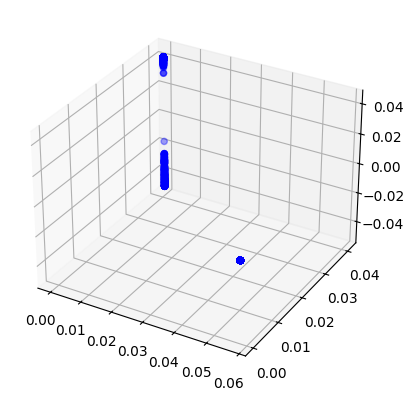

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(U_circles_10[:, 0], U_circles_10[:, 1], U_circles_10[:, 2], c='blue', marker='o')

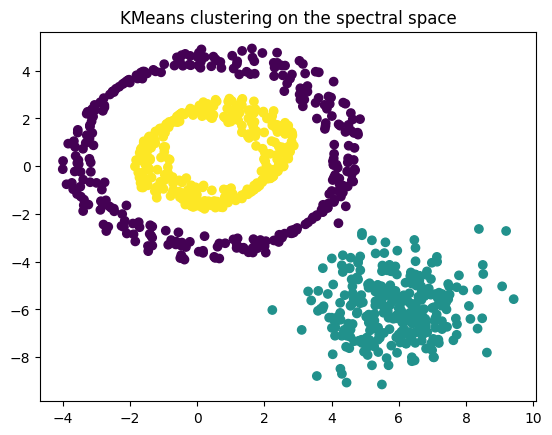

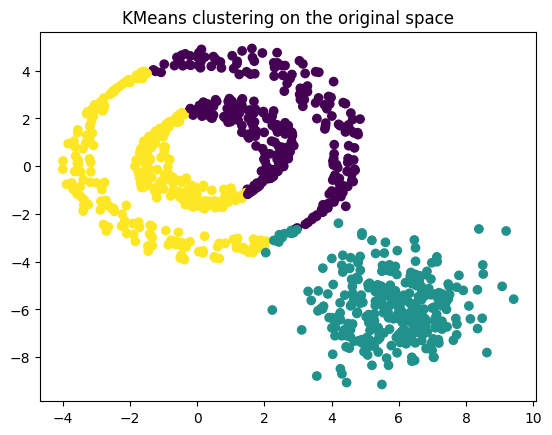

Silhouette score for KMeans clustering applied on the 3-dimensional points:0.32326843682162765
Silhouette score for KMeans clustering applied on the original points:0.47444975618735247
Adjusted rand score: 0.4701072314954328


In [ ]:
# Kmeans clustering on the spectral space
k_kmeans = 3
kmeans = KMeans(n_clusters = k_kmeans, random_state = 42)
labels_km_spec = kmeans.fit_predict(np.asarray(U_circles_10))

plt.scatter(circles.loc[:, 'x'], circles.loc[:, 'y'], c = labels_km_spec, cmap = 'viridis')
plt.title('KMeans clustering on the spectral space')
plt.show()

# Kmeans clustering on the original space
kmeans_circle = KMeans(n_clusters = k_kmeans, random_state = 42)
labels_km_circles = kmeans_circle.fit_predict(circles)
plt.scatter(circles.loc[:, 'x'], circles.loc[:, 'y'], c = labels_km_circles, cmap = 'viridis')
plt.title('KMeans clustering on the original space')
plt.show()

# Evaluation
silh_km_spec = silhouette_score(circles, labels_km_spec)
silh_km_circles = silhouette_score(circles, labels_km_circles)
adj_km = adjusted_rand_score(labels_km_spec, labels_km_circles)
print(f'Silhouette score for KMeans clustering applied on the {M}-dimensional points:{silh_km_spec}')
print(f'Silhouette score for KMeans clustering applied on the original points:{silh_km_circles}')
print(f'Adjusted rand score: {adj_km}')

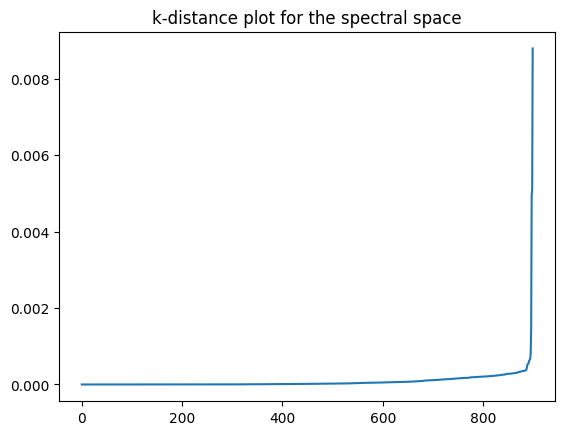

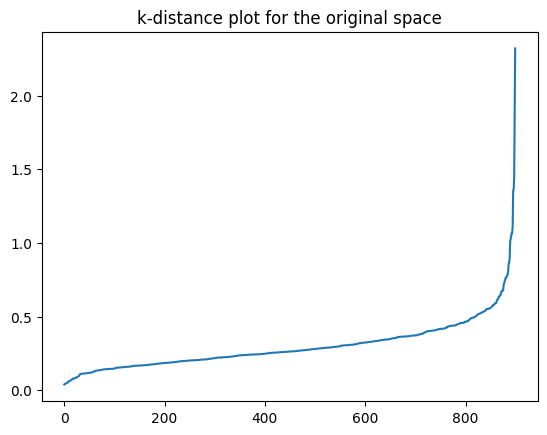

In [ ]:
# Estimate the optimal eps for DBSCAN given the k-nearest neighbors
neighbors = NearestNeighbors(n_neighbors=5)
neighbors_fit = neighbors.fit(np.asarray(U_circles_10))
distances, indices = neighbors_fit.kneighbors(np.asarray(U_circles_10))
distances = np.sort(distances, axis=0)
distances = distances[:,-1]
plt.plot(distances)
plt.title('k-distance plot for the spectral space')
plt.show()

# Estimate the optimal eps for DBSCAN given the k-nearest neighbors
neighbors = NearestNeighbors(n_neighbors=5)
neighbors_fit = neighbors.fit(circles)
distances, indices = neighbors_fit.kneighbors(circles)
distances = np.sort(distances, axis=0)
distances = distances[:,-1]
plt.plot(distances)
plt.title('k-distance plot for the original space')
plt.show()

Number of clusters found by DBSCAN on the spectral space: 4


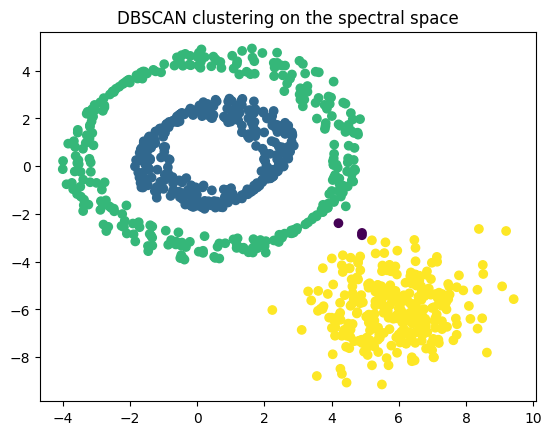

Number of clusters found by DBSCAN on the original space: 4


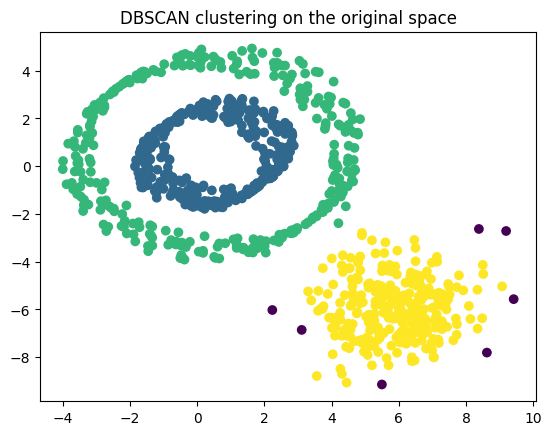

Silhouette score for DBSCAN clustering applied on the 3-dimensional points:0.1612804537308867
Silhouette score for DBSCAN clustering applied on the original points: 0.225795331124162
Adjusted rand score: 0.9837867296845562


In [ ]:
# DBSCAN on the spectral space
dbscan = DBSCAN(eps = 0.0012, min_samples=5)
labels_db_spec = dbscan.fit_predict(np.asarray(U_circles_10))
print(f'Number of clusters found by DBSCAN on the spectral space: {len(np.unique(labels_db_spec))}')

plt.scatter(circles.loc[:, 'x'], circles.loc[:, 'y'], c = labels_db_spec, cmap = 'viridis')
plt.title('DBSCAN clustering on the spectral space')
plt.show()

# DBSCAN on the original space
dbscan2 = DBSCAN(eps = 0.8, min_samples=5)
labels_db_circles = dbscan2.fit_predict(circles)
print(f'Number of clusters found by DBSCAN on the original space: {len(np.unique(labels_db_circles))}')

plt.scatter(circles.loc[:, 'x'], circles.loc[:, 'y'], c = labels_db_circles, cmap = 'viridis')
plt.title('DBSCAN clustering on the original space')
plt.show()

# Evaluation
silh_db_spec = silhouette_score(np.asarray(circles), labels_db_spec)
silh_db_circles = silhouette_score(np.asarray(circles), labels_db_circles)
adj_db = adjusted_rand_score(labels_db_spec, labels_db_circles)
print(f'Silhouette score for DBSCAN clustering applied on the {M}-dimensional points:{silh_db_spec}')
print(f'Silhouette score for DBSCAN clustering applied on the original points: {silh_db_circles}')
print(f'Adjusted rand score: {adj_db}')

In [ ]:
# Comparison between the two clustering methods
adj_db_km = adjusted_rand_score(labels_db_spec, labels_km_spec)
print(f'Adjusted rand score between the Kmeans clustering and the DBSCAN clustering: {adj_db_km}')

Adjusted rand score between the Kmeans clustering and the DBSCAN clustering: 0.9950141554013233


Second try: we choose the 20 nearest neighbor for each point

In [ ]:
k = 20
L_circles_20, W_circles_20, D_circles_20 = compute_L_W_D(circles, k)

In [ ]:
# Compute the dimension of the Laplacian matrix
rank = np.linalg.matrix_rank(L_circles_20.todense())

# Compute the dimension of the Laplacian null space, therefore the number of null eigenvalues
null_eigs = L_circles_20.shape[0] - rank

print(f'The number of null eigenvalues is {null_eigs}, that is also the number of connected components in the graph')

# Compute the eigenvalues and eigenvectors of the Laplacian matrix
eigenvalues, eigenvectors = np.linalg.eigh(L_circles_20.todense())

print(f'The smallest eigenvalue of the Laplacian matrix are {eigenvalues[:20]}')


The number of null eigenvalues is 1, that is also the number of connected components in the graph
The smallest eigenvalue of the Laplacian matrix are [6.55434599e-16 8.42421766e-03 3.96398962e-02 1.27157231e-01
 1.34045854e-01 2.23169191e-01 2.35431757e-01 4.46967824e-01
 4.96876561e-01 5.51055796e-01 6.53814930e-01 7.38601559e-01
 8.08344215e-01 9.61793387e-01 1.03420423e+00 1.38017389e+00
 1.55153630e+00 1.66815179e+00 1.71928580e+00 1.77699295e+00]


Hence we define U_circles_20 as the matrix of the first M eigenvectors of the Laplacian matrix

In [ ]:
M = 3 # Number of eigenvectors that we choose to generate the new space
U_circles_20 = eigenvectors[:, :M]

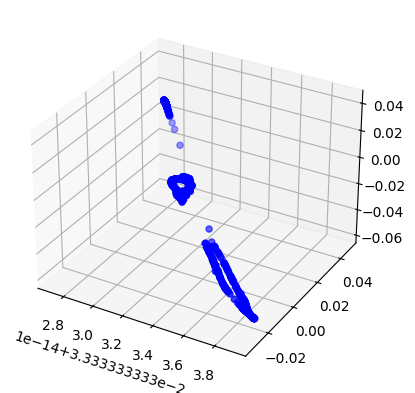

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(U_circles_20[:, 0], U_circles_20[:, 1], U_circles_20[:, 2], c='blue', marker='o')

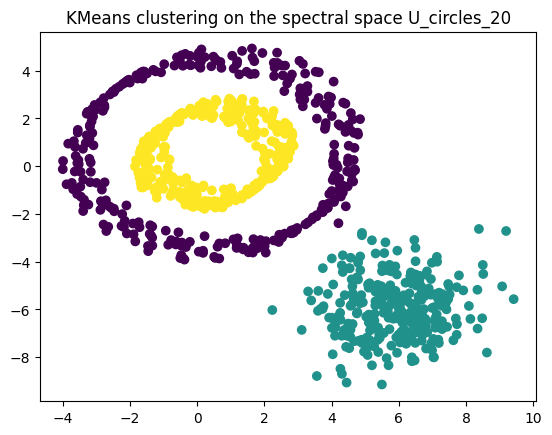

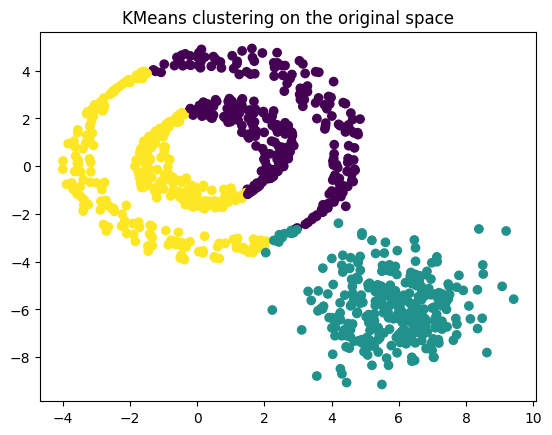

Silhouette score for KMeans clustering applied on the 3-dimensional points:0.32326843682162765
Silhouette score for KMeans clustering applied on the original points:0.47444975618735247
Adjusted rand score: 0.4701072314954328


In [ ]:
# Kmeans clustering on the spectral space
k_kmeans = 3
kmeans_20 = KMeans(n_clusters = k_kmeans, random_state = 42)
labels_km_spec = kmeans_20.fit_predict(np.asarray(U_circles_20))

plt.scatter(circles.loc[:, 'x'], circles.loc[:, 'y'], c = labels_km_spec, cmap = 'viridis')
plt.title('KMeans clustering on the spectral space U_circles_20')
plt.show()

# Kmeans clustering on the original space
plt.scatter(circles.loc[:, 'x'], circles.loc[:, 'y'], c = labels_km_circles, cmap = 'viridis')
plt.title('KMeans clustering on the original space')
plt.show()

# Evaluation
silh_km_spec = silhouette_score(np.asarray(circles), labels_km_spec)
adj_km = adjusted_rand_score(labels_km_spec, labels_km_circles)
print(f'Silhouette score for KMeans clustering applied on the {M}-dimensional points:{silh_km_spec}')
print(f'Silhouette score for KMeans clustering applied on the original points:{silh_km_circles}')
print(f'Adjusted rand score: {adj_km}')

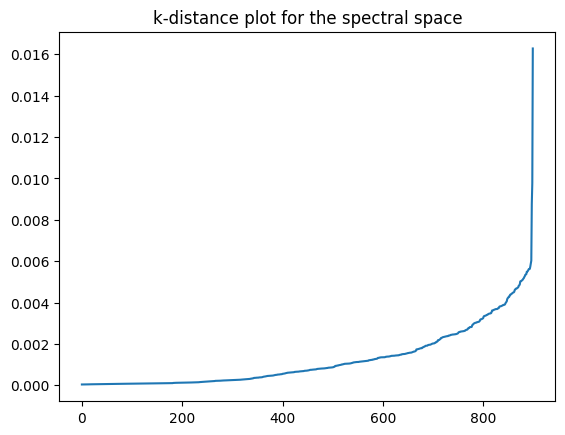

In [ ]:
# Estimate the optimal eps for DBSCAN given the k-nearest neighbors
neighbors = NearestNeighbors(n_neighbors=k)
neighbors_fit = neighbors.fit(np.asarray(U_circles_20))
distances, indices = neighbors_fit.kneighbors(np.asarray(U_circles_20))
distances = np.sort(distances, axis=0)
distances = distances[:,-1]
plt.plot(distances)
plt.title('k-distance plot for the spectral space')
plt.show()

Number of clusters found by DBSCAN on the spectral space: 4


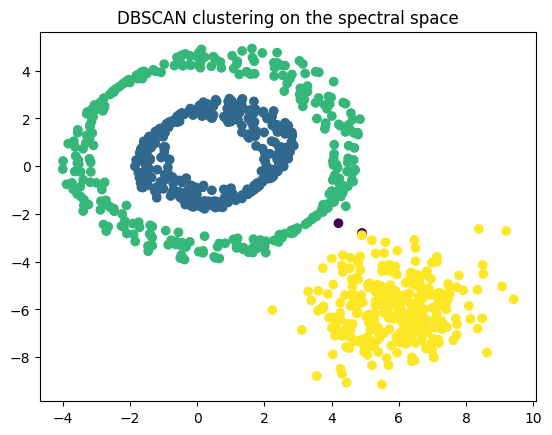

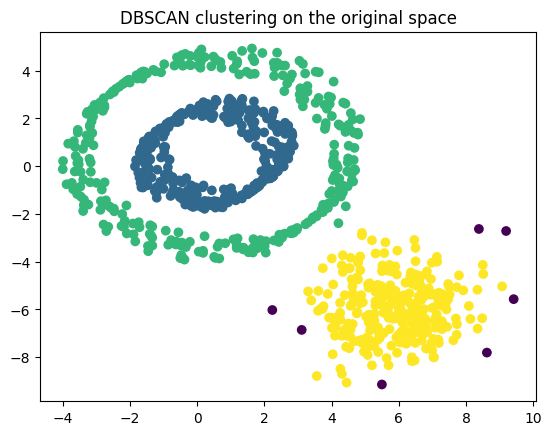

Silhouette score for DBSCAN clustering applied on the 3-dimensional points:0.16110984675031592
Silhouette score for DBSCAN clustering applied on the original points: 0.225795331124162
Adjusted rand score: 0.9853681854685423


In [ ]:
# DBSCAN on the spectral space
dbscan = DBSCAN(eps = 0.006, min_samples=k)
labels_db_spec = dbscan.fit_predict(np.asarray(U_circles_20))
print(f'Number of clusters found by DBSCAN on the spectral space: {len(np.unique(labels_db_spec))}')

plt.scatter(circles.loc[:, 'x'], circles.loc[:, 'y'], c = labels_db_spec, cmap = 'viridis')
plt.title('DBSCAN clustering on the spectral space')
plt.show()

# DBSCAN on the original space

plt.scatter(circles.loc[:, 'x'], circles.loc[:, 'y'], c = labels_db_circles, cmap = 'viridis')
plt.title('DBSCAN clustering on the original space')
plt.show()

# Evaluation
silh_db_spec = silhouette_score(np.asarray(circles), labels_db_spec)
silh_db_circles = silhouette_score(np.asarray(circles), labels_db_circles)
adj_db = adjusted_rand_score(labels_db_spec, labels_db_circles)
print(f'Silhouette score for DBSCAN clustering applied on the {M}-dimensional points:{silh_db_spec}')
print(f'Silhouette score for DBSCAN clustering applied on the original points: {silh_db_circles}')
print(f'Adjusted rand score: {adj_db}')

In [ ]:
# Comparison between the two clustering methods
adj_db_km = adjusted_rand_score(labels_db_spec, labels_km_spec)
print(f'Adjusted rand score between the Kmeans clustering and the DBSCAN clustering: {adj_db_km}')

Adjusted rand score between the Kmeans clustering and the DBSCAN clustering: 0.9966611990315535


Last try: we finish with the 40 nearest neighbors

In [ ]:
k = 40
L_circles_40, W_circles_40, D_circles_40 = compute_L_W_D(circles, k)

In [ ]:
# Compute the dimension of the Laplacian matrix
rank = np.linalg.matrix_rank(L_circles_40.todense())

# Compute the dimension of the Laplacian null space, and therefore the number of null eigenvalues
null_eigs = L_circles_40.shape[0] - rank

print(f'The number of null eigenvalues is {null_eigs}, that is also the number of connected components in the graph')

# Compute the eigenvalues and eigenvectors of the Laplacian matrix
eigenvalues, eigenvectors = np.linalg.eigh(L_circles_40.todense())

print(f'The smallest eigenvalue of the Laplacian matrix are {eigenvalues[:20]}')


The number of null eigenvalues is 1, that is also the number of connected components in the graph
The smallest eigenvalue of the Laplacian matrix are [1.42264119e-15 5.40150245e-02 6.64407425e-01 7.32564289e-01
 7.69191176e-01 1.18891856e+00 2.08466866e+00 2.13852748e+00
 2.43676139e+00 2.52918000e+00 2.68229630e+00 4.10299666e+00
 4.40984969e+00 4.70443900e+00 4.95605317e+00 5.42382879e+00
 5.75438668e+00 6.50984185e+00 7.03882673e+00 7.27953275e+00]


In [ ]:
M = 4   # Number of eigenvectors that we choose to generate the new space
U_circles_40 = eigenvectors[:, :M]

print(f'Hence we define U_circles_40 as the matrix of the first {M} eigenvectors of the Laplacian matrix')

Hence we define U_circles_40 as the matrix of the first 4 eigenvectors of the Laplacian matrix


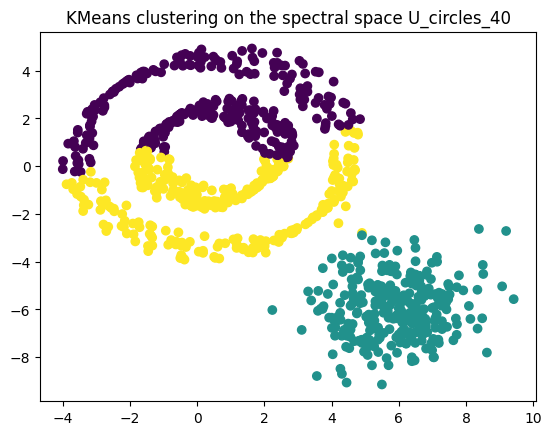

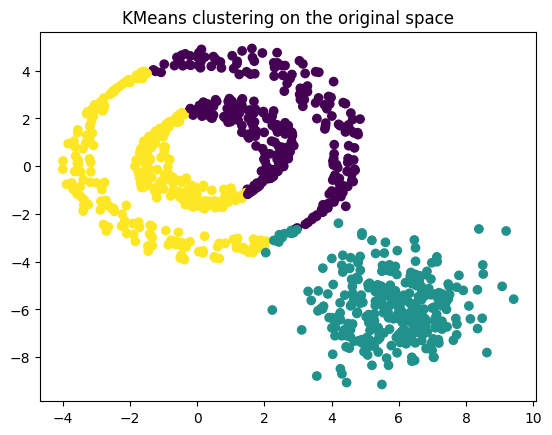

Silhouette score for KMeans clustering applied on the 4-dimensional points:0.4463995587417714
Silhouette score for KMeans clustering applied on the original points:0.47444975618735247
Adjusted rand score: 0.5031932801842869


In [ ]:
# Kmeans clustering on the spectral space
k_kmeans = 3
kmeans_40 = KMeans(n_clusters = k_kmeans, random_state = 42)
labels_km_spec = kmeans_40.fit_predict(np.asarray(U_circles_40))

plt.scatter(circles.loc[:, 'x'], circles.loc[:, 'y'], c = labels_km_spec, cmap = 'viridis')
plt.title('KMeans clustering on the spectral space U_circles_40')
plt.show()

# Kmeans clustering on the original space
plt.scatter(circles.loc[:, 'x'], circles.loc[:, 'y'], c = labels_km_circles, cmap = 'viridis')
plt.title('KMeans clustering on the original space')
plt.show()

# Evaluation
silh_km_spec = silhouette_score(np.asarray(circles), labels_km_spec)
adj_km = adjusted_rand_score(labels_km_spec, labels_km_circles)
print(f'Silhouette score for KMeans clustering applied on the {M}-dimensional points:{silh_km_spec}')
print(f'Silhouette score for KMeans clustering applied on the original points:{silh_km_circles}')
print(f'Adjusted rand score: {adj_km}')

Seeing the bad perfomance for U_circles_40 in the KMeans with k =3, we try to reduce the number of clusters.

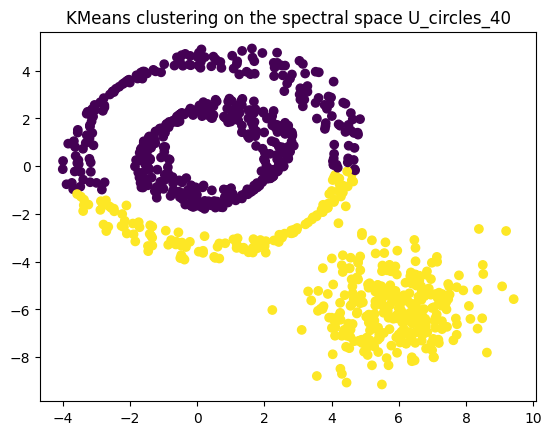

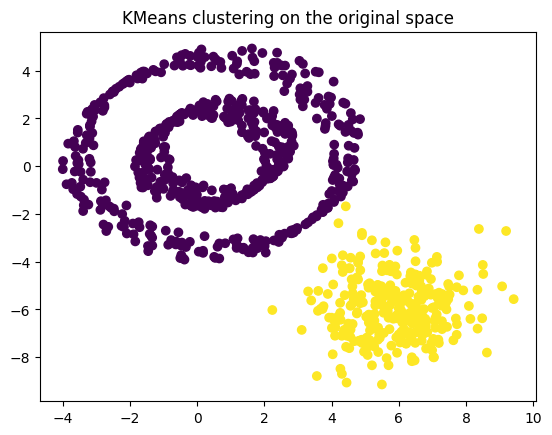

Silhouette score for KMeans clustering applied on the 4-dimensional points:0.48917425960742955
Silhouette score for KMeans clustering applied on the original points:0.48917425960742955
Adjusted rand score: 0.5241588587178106


In [ ]:
# Kmeans clustering on the spectral space
k_kmeans = 2
kmeans_40_2 = KMeans(n_clusters = k_kmeans, random_state = 42)
labels_km_spec_2 = kmeans_40_2.fit_predict(np.asarray(U_circles_40))

plt.scatter(circles.loc[:, 'x'], circles.loc[:, 'y'], c = labels_km_spec_2, cmap = 'viridis')
plt.title('KMeans clustering on the spectral space U_circles_40')
plt.show()

# Kmeans clustering on the original space
kmeans_circle_2 = KMeans(n_clusters = k_kmeans, random_state = 42)
labels_km_circles_2 = kmeans_circle_2.fit_predict(circles)
plt.scatter(circles.loc[:, 'x'], circles.loc[:, 'y'], c = labels_km_circles_2, cmap = 'viridis')
plt.title('KMeans clustering on the original space')
plt.show()

# Evaluation
silh_km_spec_2 = silhouette_score(np.asarray(circles), labels_km_spec_2)
silh_km_circles_2 = silhouette_score(np.asarray(circles), labels_km_spec_2)
adj_km_2 = adjusted_rand_score(labels_km_spec_2, labels_km_circles_2)
print(f'Silhouette score for KMeans clustering applied on the {M}-dimensional points:{silh_km_spec_2}')
print(f'Silhouette score for KMeans clustering applied on the original points:{silh_km_circles_2}')
print(f'Adjusted rand score: {adj_km_2}')

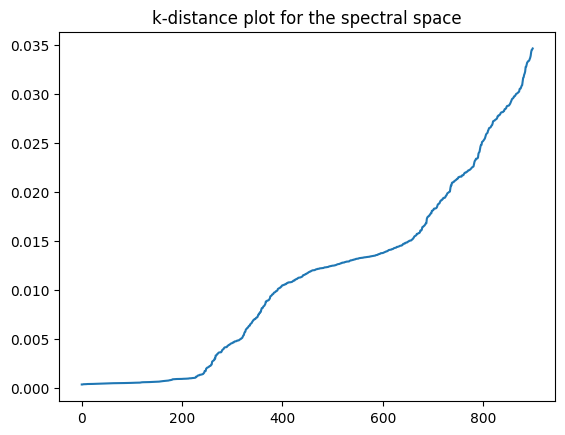

In [ ]:
# Estimate the optimal eps for DBSCAN given the k-nearest neighbors
neighbors = NearestNeighbors(n_neighbors=k)
neighbors_fit = neighbors.fit(np.asarray(U_circles_40))
distances, indices = neighbors_fit.kneighbors(np.asarray(U_circles_40))
distances = np.sort(distances, axis=0)
distances = distances[:,-1]
plt.plot(distances)
plt.title('k-distance plot for the spectral space')
plt.show()

Number of clusters found by DBSCAN on the spectral space: 2


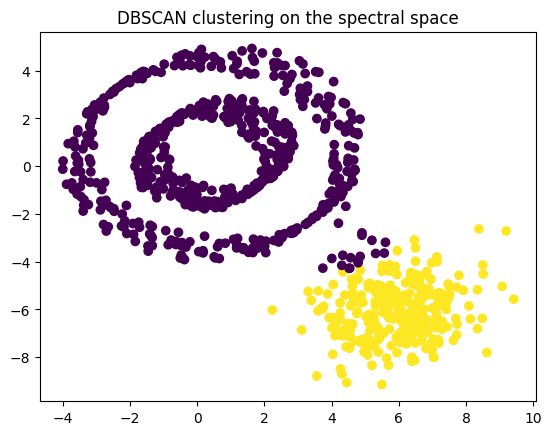

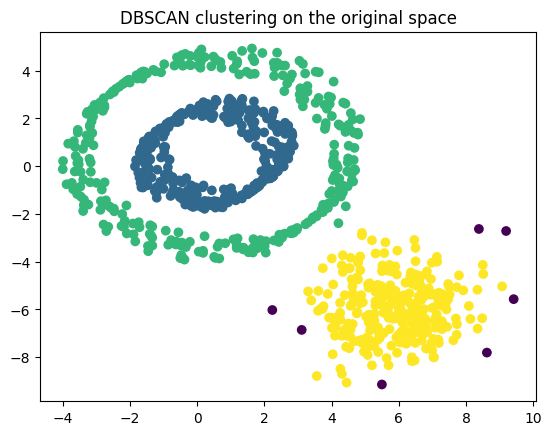

Silhouette score for DBSCAN clustering applied on the 4-dimensional points:0.5678063871957475
Silhouette score for DBSCAN clustering applied on the original points: 0.225795331124162
Adjusted rand score: 0.49609865320153373


In [ ]:
# DBSCAN on the spectral space
dbscan = DBSCAN(eps = 0.0032, min_samples=k)
labels_db_spec = dbscan.fit_predict(np.asarray(U_circles_40))
print(f'Number of clusters found by DBSCAN on the spectral space: {len(np.unique(labels_db_spec))}')

plt.scatter(circles.loc[:, 'x'], circles.loc[:, 'y'], c = labels_db_spec, cmap = 'viridis')
plt.title('DBSCAN clustering on the spectral space')
plt.show()

# DBSCAN on the original space

plt.scatter(circles.loc[:, 'x'], circles.loc[:, 'y'], c = labels_db_circles, cmap = 'viridis')
plt.title('DBSCAN clustering on the original space')
plt.show()

# Evaluation
silh_db_spec = silhouette_score(np.asarray(circles), labels_db_spec)
silh_db_circles = silhouette_score(np.asarray(circles), labels_db_circles)
adj_db = adjusted_rand_score(labels_db_spec, labels_db_circles)
print(f'Silhouette score for DBSCAN clustering applied on the {M}-dimensional points:{silh_db_spec}')
print(f'Silhouette score for DBSCAN clustering applied on the original points: {silh_db_circles}')
print(f'Adjusted rand score: {adj_db}')

In [ ]:
# Comparison between the two clustering methods
adj_db_km = adjusted_rand_score(labels_db_spec, labels_km_spec)
print(f'Adjusted rand score between the Kmeans clustering and the DBSCAN clustering: {adj_db_km}')

Adjusted rand score between the Kmeans clustering and the DBSCAN clustering: 0.5067274605273342


# Spiral dataset

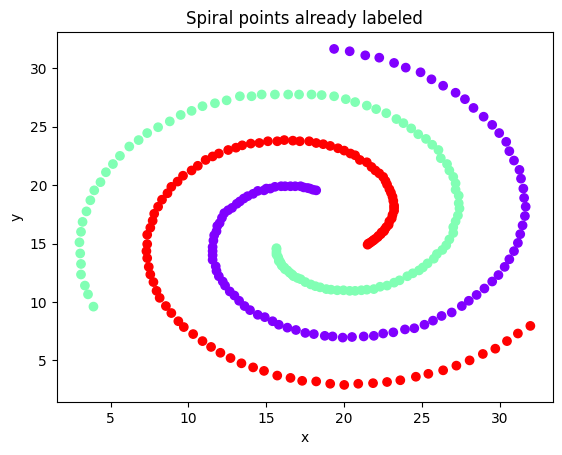

The number of clusters in the spiral dataset is 3


In [ ]:
plt.scatter(spirals.loc[:, 'x'], spirals.loc[:, 'y'], c=spirals['label'], cmap='rainbow')
plt.title('Spiral points already labeled')
plt.xlabel('x')
plt.ylabel('y')
plt.show()
print(f'The number of clusters in the spiral dataset is {len(np.unique(spirals["label"]))}')

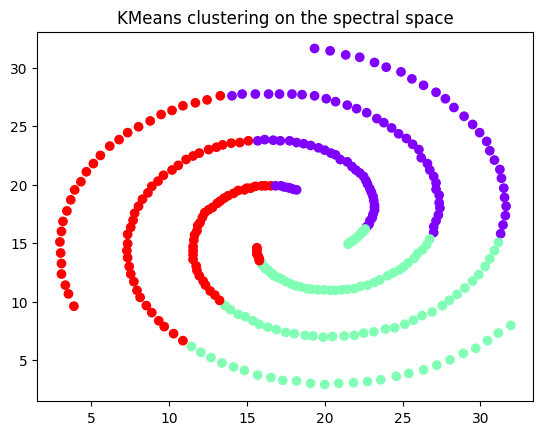

Silhouette score for KMeans clustering applied on the original points:0.35659853889542537
Adjusted rand score with the original labels: -0.0059621280246944025


In [ ]:
# Kmeans on the orginal points
k_kmeans = 3
kmeans = KMeans(n_clusters = k_kmeans, random_state = 42)
labels_km_spirals = kmeans.fit_predict(spirals.loc[:,['x', 'y']])

plt.scatter(spirals.loc[:, 'x'], spirals.loc[:, 'y'], c = labels_km_spirals, cmap = 'rainbow')
plt.title('KMeans clustering on the spectral space')
plt.show()

silh_km_spirals = silhouette_score(spirals, labels_km_spirals)
adj_km = adjusted_rand_score(labels_km_spirals, spirals['label'])
print(f'Silhouette score for KMeans clustering applied on the original points:{silh_km_spirals}')
print(f'Adjusted rand score with the original labels: {adj_km}')

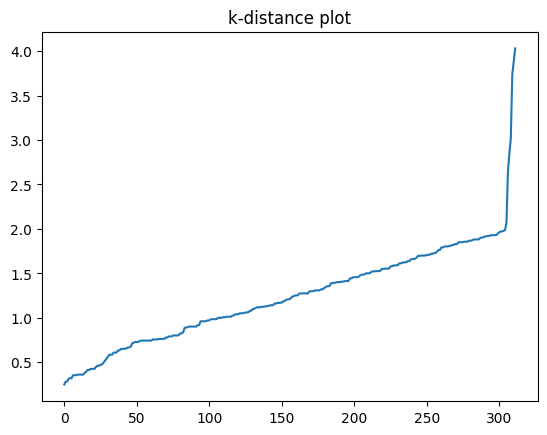

In [ ]:
# Estimate the optimal eps for DBSCAN given the k-nearest neighbors
neighbors = NearestNeighbors(n_neighbors=5)
neighbors_fit = neighbors.fit(spirals.loc[:,['x', 'y']])
distances, indices = neighbors_fit.kneighbors(spirals.loc[:,['x', 'y']])
distances = np.sort(distances, axis=0)
distances = distances[:,-1]
plt.plot(distances)
plt.title('k-distance plot')
plt.show()

Number of clusters found by DBSCAN on the spectral space: 3


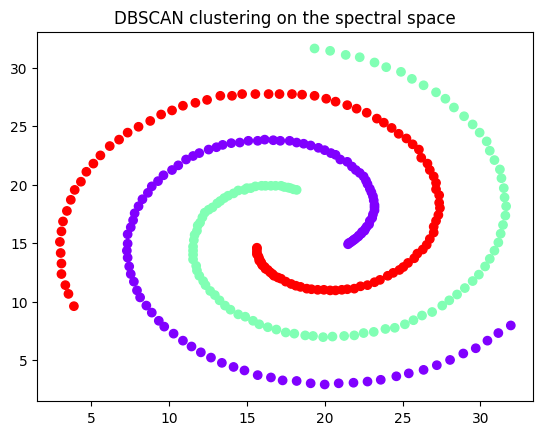

Silhouette score for DBSCAN clustering applied on the 4-dimensional points:0.008339684452069632
Adjusted rand score: 1.0


In [ ]:
dbscan = DBSCAN(eps = 2.1, min_samples=5)
labels_db_spirals = dbscan.fit_predict(spirals.loc[:,['x', 'y']])
print(f'Number of clusters found by DBSCAN on the spectral space: {len(np.unique(labels_db_spirals))}')

plt.scatter(spirals.loc[:, 'x'], spirals.loc[:, 'y'], c = labels_db_spirals, cmap = 'rainbow')
plt.title('DBSCAN clustering on the spectral space')
plt.show()

silh_db_spirals = silhouette_score(spirals, labels_db_spirals)
adj_db = adjusted_rand_score(labels_db_spirals, spirals['label'])
print(f'Silhouette score for DBSCAN clustering applied on the {M}-dimensional points:{silh_db_spirals}')
print(f'Adjusted rand score: {adj_db}')

First try: we try to create the spectral space for the 10 nearest points

In [ ]:
k = 10
L_spiral_10, W_spiral_10, D_spiral_10 = compute_L_W_D(spirals, k)

# Compute the dimension of the Laplacian matrix
rank = np.linalg.matrix_rank(L_spiral_10.todense())

# Compute the dimension of the Laplacian null space, and therefore the number of null eigenvalues
null_eigs = L_spiral_10.shape[0] - rank

print(f'The number of null eigenvalues is {null_eigs}, that is also the number of connected components in the graph')

# Compute the eigenvalues and eigenvectors of the Laplacian matrix
eigenvalues, eigenvectors = np.linalg.eigh(L_spiral_10.todense())

print(f'The smallest eigenvalue of the Laplacian matrix are {eigenvalues[:20]}')


The number of null eigenvalues is 1, that is also the number of connected components in the graph
The smallest eigenvalue of the Laplacian matrix are [-6.62315165e-16  7.12477994e-03  7.64665412e-03  2.31849296e-02
  4.15137801e-02  4.47134273e-02  1.09624621e-01  1.23440612e-01
  1.28583422e-01  1.50184290e-01  1.60692642e-01  2.50920384e-01
  2.73188246e-01  2.99593790e-01  3.21332092e-01  3.60427358e-01
  4.40139580e-01  4.53664441e-01  5.39427895e-01  5.66160715e-01]


In [ ]:
M = 3
U_spirals_10 = eigenvectors[:, :M]

print(f'Hence we define U_spirales_10 as the matrix of the first {M} eigenvectors of the Laplacian matrix')

Hence we define U_spirales_10 as the matrix of the first 3 eigenvectors of the Laplacian matrix


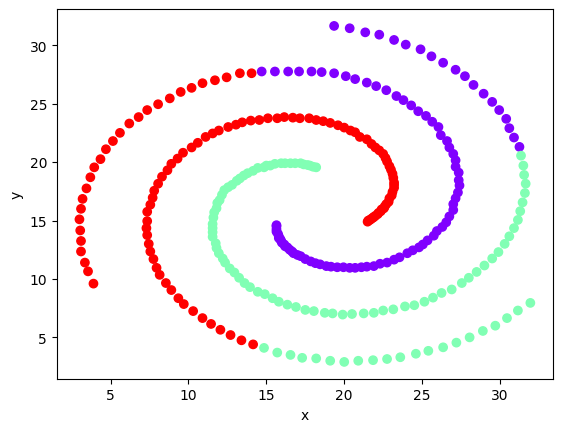

Silhouette score for KMeans clustering applied on the 3-dimensional points:0.06736679362567803
Adjusted rand score with the original labels: 0.48587064446954364


In [ ]:
k_kmeans = 3
kmeans = KMeans(n_clusters = k_kmeans, random_state = 42)
labels_km_spec = kmeans.fit_predict(np.asarray(U_spirals_10))

plt.scatter(spirals.loc[:, 'x'], spirals.loc[:, 'y'], c = labels_km_spec, cmap = 'rainbow')
# plt.title('KMeans clustering on the spectral space from the first 3 eigenvectors')
plt.xlabel('x')
plt.ylabel('y')
plt.show()

silh_km_spec = silhouette_score(spirals, labels_km_spec)
adj_km = adjusted_rand_score(labels_km_spec, spirals['label'])
print(f'Silhouette score for KMeans clustering applied on the {M}-dimensional points:{silh_km_spec}')
print(f'Adjusted rand score with the original labels: {adj_km}')

Number of clusters found by DBSCAN on the spectral space: 4


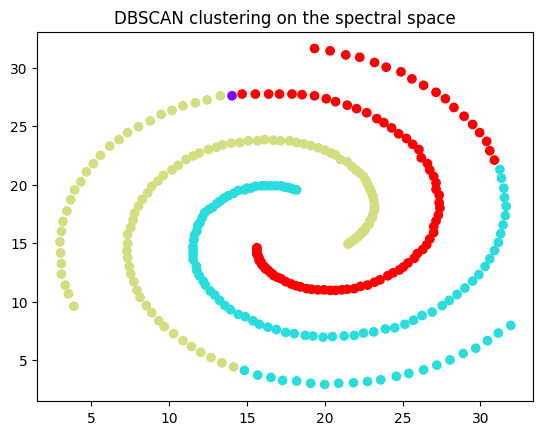

Silhouette score for DBSCAN clustering applied on the 3-dimensional points:-0.0712757507709498
Adjusted rand score: 0.4933160519222947


In [ ]:
dbscan = DBSCAN(eps = 0.012, min_samples=k)
labels_db_spec = dbscan.fit_predict(np.asarray(U_spirals_10))
print(f'Number of clusters found by DBSCAN on the spectral space: {len(np.unique(labels_db_spec))}')

plt.scatter(spirals.loc[:, 'x'], spirals.loc[:, 'y'], c = labels_db_spec, cmap = 'rainbow')
plt.title('DBSCAN clustering on the spectral space')
plt.show()

silh_db_spec = silhouette_score(spirals, labels_db_spec)
adj_db = adjusted_rand_score(labels_db_spec, spirals['label'])
print(f'Silhouette score for DBSCAN clustering applied on the {M}-dimensional points:{silh_db_spec}')
print(f'Adjusted rand score: {adj_db}')

In [ ]:
M = 11
U_spirals_10 = eigenvectors[:, :M]

print(f'Hence we define U_spirales_10 as the matrix of the first {M} eigenvectors of the Laplacian matrix')

Hence we define U_spirales_10 as the matrix of the first 11 eigenvectors of the Laplacian matrix


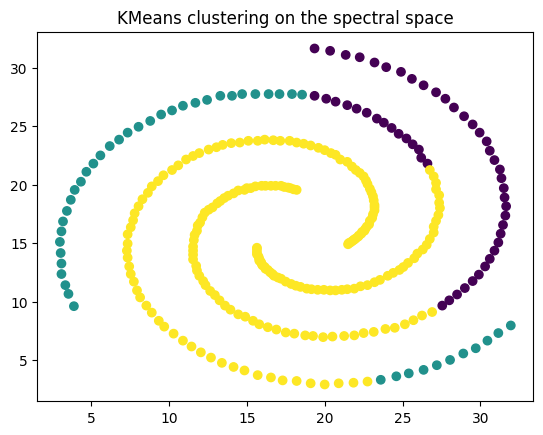

Silhouette score for KMeans clustering applied on the 11-dimensional points:0.19888742145402105
Adjusted rand score with the original labels: 0.0804115559912958


In [ ]:
k_kmeans = 3
kmeans = KMeans(n_clusters = k_kmeans, random_state = 42)
labels_km_spec = kmeans.fit_predict(np.asarray(U_spirals_10))

plt.scatter(spirals.loc[:, 'x'], spirals.loc[:, 'y'], c = labels_km_spec, cmap = 'viridis')
plt.title('KMeans clustering on the spectral space')
plt.show()

silh_km_spec = silhouette_score(spirals, labels_km_spec)
adj_km = adjusted_rand_score(labels_km_spec, spirals['label'])
print(f'Silhouette score for KMeans clustering applied on the {M}-dimensional points:{silh_km_spec}')
print(f'Adjusted rand score with the original labels: {adj_km}')

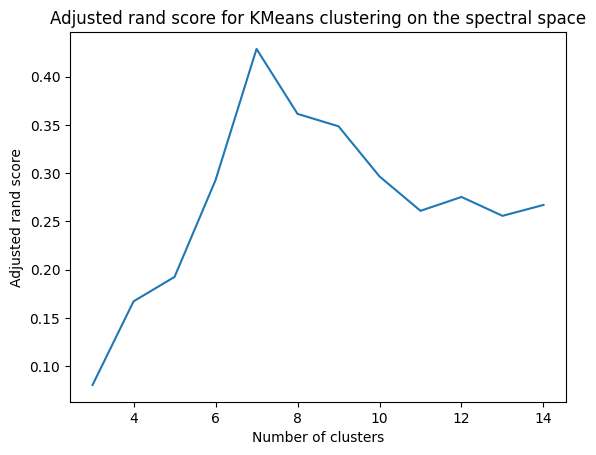

In [ ]:
silh_10 = {}
for k_kmeans in range(3, 15):
    kmeans = KMeans(n_clusters = k_kmeans, random_state = 42)
    labels_km_spec = kmeans.fit_predict(np.asarray(U_spirals_10))
    adj_km = adjusted_rand_score(labels_km_spec, spirals['label'])
    silh_10[k_kmeans] = adj_km

plt.plot(list(silh_10.keys()), list(silh_10.values()))
plt.xlabel('Number of clusters')
plt.ylabel('Adjusted rand score')
plt.title('Adjusted rand score for KMeans clustering on the spectral space')
plt.show()

The optimal number of clusters is 7


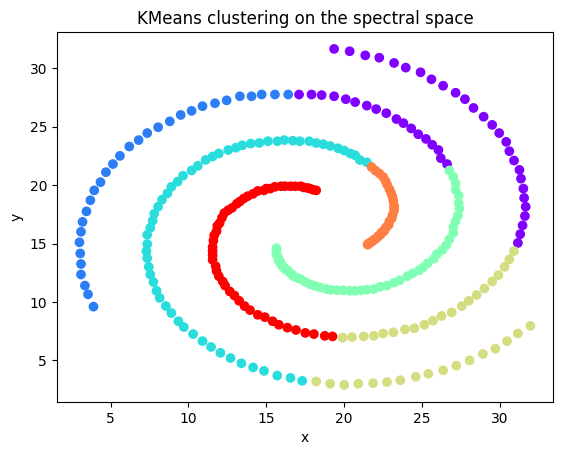

Silhouette score for KMeans clustering applied on the 11-dimensional points:0.15770831876633068
Adjusted rand score with the original labels: 0.4288653467614152


In [ ]:
k_kmeans = dict(sorted(silh_10.items(), key=lambda item: item[1])).popitem()[0]
print(f'The optimal number of clusters is {k_kmeans}')
kmeans = KMeans(n_clusters = k_kmeans, random_state = 42)
labels_km_spec = kmeans.fit_predict(np.asarray(U_spirals_10))

plt.scatter(spirals.loc[:, 'x'], spirals.loc[:, 'y'], c = labels_km_spec, cmap = 'rainbow')
plt.xlabel('x')
plt.ylabel('y')
plt.title('KMeans clustering on the spectral space')
plt.show()

silh_km_spec = silhouette_score(spirals, labels_km_spec)
adj_km = adjusted_rand_score(labels_km_spec, spirals['label'])
print(f'Silhouette score for KMeans clustering applied on the {M}-dimensional points:{silh_km_spec}')
print(f'Adjusted rand score with the original labels: {adj_km}')

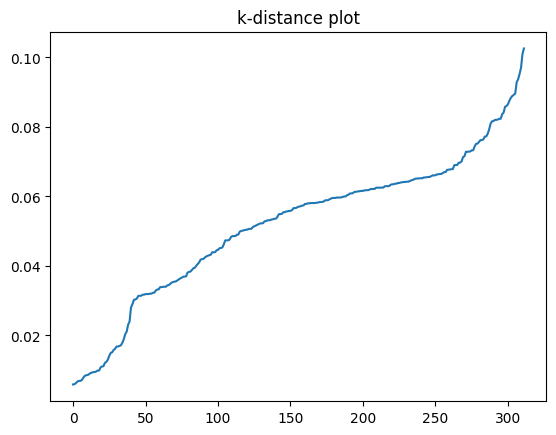

In [ ]:
# Estimate the optimal eps for DBSCAN given the k-nearest neighbors
neighbors = NearestNeighbors(n_neighbors=k)
neighbors_fit = neighbors.fit(np.asarray(U_spirals_10))
distances, indices = neighbors_fit.kneighbors(np.asarray(U_spirals_10))
distances = np.sort(distances, axis=0)
distances = distances[:,-1]
plt.plot(distances)
plt.title('k-distance plot')
plt.show()

Number of clusters found by DBSCAN on the spectral space: 6


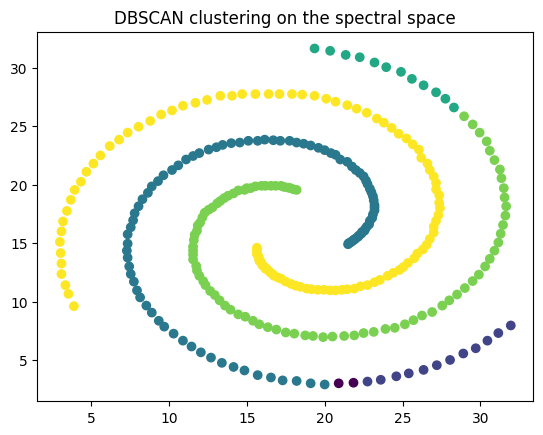

Silhouette score for DBSCAN clustering applied on the 11-dimensional points:-0.09836021288411712
Adjusted rand score: 0.884995052972028


In [ ]:
dbscan = DBSCAN(eps = 0.075, min_samples=k)
labels_db_spec = dbscan.fit_predict(np.asarray(U_spirals_10))
print(f'Number of clusters found by DBSCAN on the spectral space: {len(np.unique(labels_db_spec))}')

plt.scatter(spirals.loc[:, 'x'], spirals.loc[:, 'y'], c = labels_db_spec, cmap = 'viridis')
plt.title('DBSCAN clustering on the spectral space')
plt.show()

silh_db_spec = silhouette_score(spirals, labels_db_spec)
adj_db = adjusted_rand_score(labels_db_spec, spirals['label'])
print(f'Silhouette score for DBSCAN clustering applied on the {M}-dimensional points:{silh_db_spec}')
print(f'Adjusted rand score: {adj_db}')

Second try: we try with the 20 nearest neighbors

In [ ]:
k = 20
L_spiral_20, W_spiral_20, D_spiral_20 = compute_L_W_D(spirals, k)

# Compute the dimension of the Laplacian matrix
rank = np.linalg.matrix_rank(L_spiral_20.todense())

# Compute the dimension of the Laplacian null space, and therefore the number of null eigenvalues
null_eigs = L_spiral_20.shape[0] - rank

print(f'The number of null eigenvalues is {null_eigs}, that is also the number of connected components in the graph')

# Compute the eigenvalues and eigenvectors of the Laplacian matrix
eigenvalues, eigenvectors = np.linalg.eigh(L_spiral_20.todense())

print(f'The smallest eigenvalue of the Laplacian matrix are {eigenvalues[:20]}')

The number of null eigenvalues is 1, that is also the number of connected components in the graph
The smallest eigenvalue of the Laplacian matrix are [-8.26164275e-16  9.84950541e-02  1.05330368e-01  2.00967206e-01
  3.30910262e-01  3.46483001e-01  3.54727478e-01  4.20358943e-01
  5.83867364e-01  7.58847687e-01  8.73416272e-01  9.29389935e-01
  1.05714224e+00  1.12340155e+00  1.22902857e+00  1.29389203e+00
  1.31758356e+00  1.43059242e+00  1.49145688e+00  1.59631882e+00]


In [ ]:
M = 7
U_spirals_20 = eigenvectors[:, :M]

print(f'Hence we define U_spirales_20 as the matrix of the first {M} eigenvectors of the Laplacian matrix')

Hence we define U_spirales_20 as the matrix of the first 7 eigenvectors of the Laplacian matrix


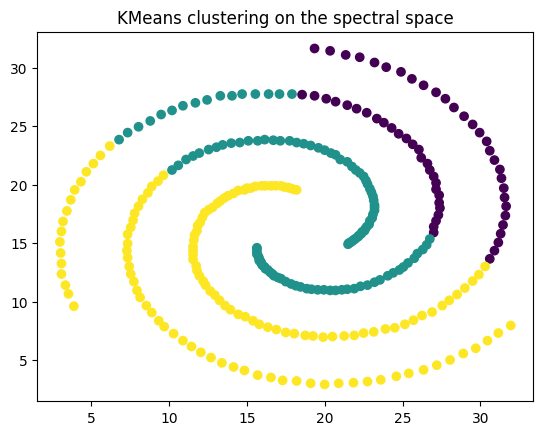

Silhouette score for KMeans clustering applied on the 7-dimensional points:0.14780301168784235
Adjusted rand score with the original labels: 0.19055933577097697


In [ ]:
k_kmeans = 3
kmeans = KMeans(n_clusters = k_kmeans, random_state = 42)
labels_km_spec = kmeans.fit_predict(np.asarray(U_spirals_20))

plt.scatter(spirals.loc[:, 'x'], spirals.loc[:, 'y'], c = labels_km_spec, cmap = 'viridis')
plt.title('KMeans clustering on the spectral space')
plt.show()

silh_km_spec = silhouette_score(spirals, labels_km_spec)
adj_km = adjusted_rand_score(labels_km_spec, spirals['label'])
print(f'Silhouette score for KMeans clustering applied on the {M}-dimensional points:{silh_km_spec}')
print(f'Adjusted rand score with the original labels: {adj_km}')

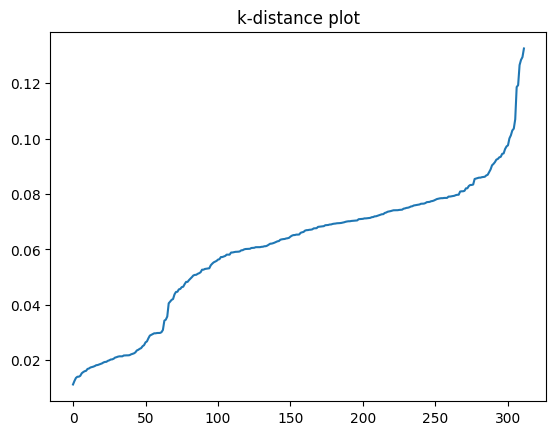

In [ ]:
# Estimate the optimal eps for DBSCAN given the k-nearest neighbors
neighbors = NearestNeighbors(n_neighbors=k)
neighbors_fit = neighbors.fit(np.asarray(U_spirals_20))
distances, indices = neighbors_fit.kneighbors(np.asarray(U_spirals_20))
distances = np.sort(distances, axis=0)
distances = distances[:,-1]
plt.plot(distances)
plt.title('k-distance plot')
plt.show()

Number of clusters found by DBSCAN on the spectral space: 2


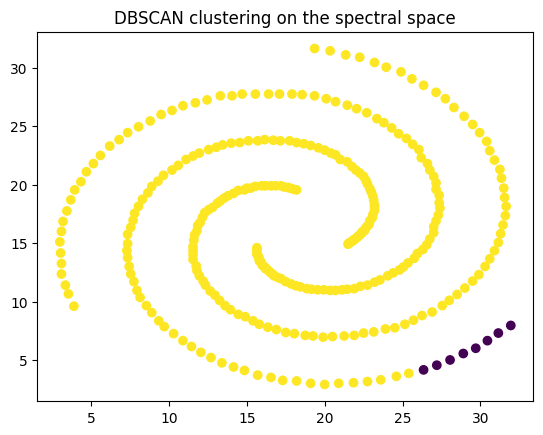

Silhouette score for DBSCAN clustering applied on the 7-dimensional points:0.2177911276938689
Adjusted rand score: 0.001379117718586233


In [ ]:
dbscan = DBSCAN(eps = 0.08, min_samples=k)
labels_db_spec = dbscan.fit_predict(np.asarray(U_spirals_20))
print(f'Number of clusters found by DBSCAN on the spectral space: {len(np.unique(labels_db_spec))}')

plt.scatter(spirals.loc[:, 'x'], spirals.loc[:, 'y'], c = labels_db_spec, cmap = 'viridis')
plt.title('DBSCAN clustering on the spectral space')
plt.show()

silh_db_spec = silhouette_score(spirals, labels_db_spec)
adj_db = adjusted_rand_score(labels_db_spec, spirals['label'])
print(f'Silhouette score for DBSCAN clustering applied on the {M}-dimensional points:{silh_db_spec}')
print(f'Adjusted rand score: {adj_db}')

Other values of eps work even worse since they return only 1 cluster.

Third try: we compute the 40 nearest neighbors, but we don't expect to have better performance

In [ ]:
k = 40
L_spiral_40, W_spiral_40, D_spiral_40 = compute_L_W_D(spirals, k)

# Compute the dimension of the Laplacian matrix
rank = np.linalg.matrix_rank(L_spiral_40.todense())

# Compute the dimension of the Laplacian null space, and therefore the number of null eigenvalues
null_eigs = L_spiral_40.shape[0] - rank

print(f'The number of null eigenvalues is {null_eigs}, that is also the number of connected components in the graph')

# Compute the eigenvalues and eigenvectors of the Laplacian matrix
eigenvalues, eigenvectors = np.linalg.eigh(L_spiral_40.todense())

print(f'The smallest eigenvalue of the Laplacian matrix are {eigenvalues[:20]}')

The number of null eigenvalues is 1, that is also the number of connected components in the graph
The smallest eigenvalue of the Laplacian matrix are [-3.84779017e-16  2.55460077e-01  2.97140120e-01  7.15474702e-01
  7.34400575e-01  9.05248248e-01  1.22541592e+00  1.28043087e+00
  1.37153738e+00  1.50736540e+00  1.71445008e+00  1.80786664e+00
  2.08051776e+00  2.19883717e+00  2.31340238e+00  2.49759702e+00
  2.52583547e+00  2.69484533e+00  2.85525515e+00  2.94540164e+00]


In [ ]:
M = 6
U_spirals_40 = eigenvectors[:, :M]

print(f'Hence we define U_spirales_20 as the matrix of the first {M} eigenvectors of the Laplacian matrix')

Hence we define U_spirales_20 as the matrix of the first 6 eigenvectors of the Laplacian matrix


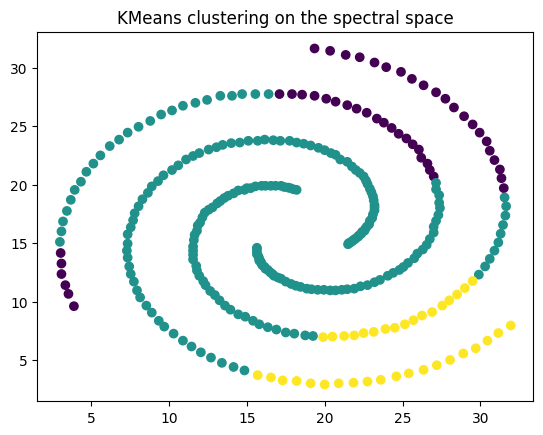

Silhouette score for KMeans clustering applied on the 6-dimensional points:0.18349613581274174
Adjusted rand score with the original labels: 0.031259480223890246


In [ ]:
k_kmeans = 3
kmeans = KMeans(n_clusters = k_kmeans, random_state = 42)
labels_km_spec = kmeans.fit_predict(np.asarray(U_spirals_40))

plt.scatter(spirals.loc[:, 'x'], spirals.loc[:, 'y'], c = labels_km_spec, cmap = 'viridis')
plt.title('KMeans clustering on the spectral space')
plt.show()

silh_km_spec = silhouette_score(spirals, labels_km_spec)
adj_km = adjusted_rand_score(labels_km_spec, spirals['label'])
print(f'Silhouette score for KMeans clustering applied on the {M}-dimensional points:{silh_km_spec}')
print(f'Adjusted rand score with the original labels: {adj_km}')

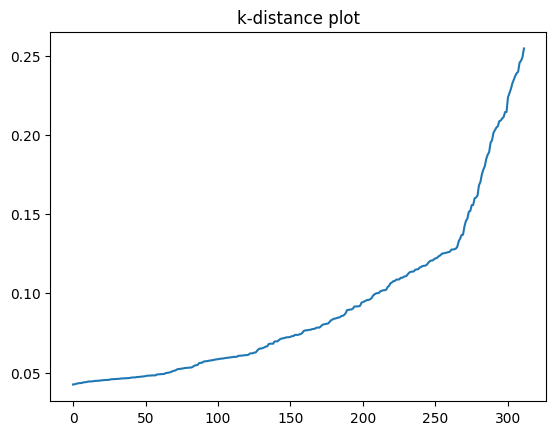

In [ ]:
# Estimate the optimal eps for DBSCAN given the k-nearest neighbors
neighbors = NearestNeighbors(n_neighbors=k)
neighbors_fit = neighbors.fit(np.asarray(U_spirals_40))
distances, indices = neighbors_fit.kneighbors(np.asarray(U_spirals_40))
distances = np.sort(distances, axis=0)
distances = distances[:,-1]
plt.plot(distances)
plt.title('k-distance plot')
plt.show()

Number of clusters found by DBSCAN on the spectral space: 2


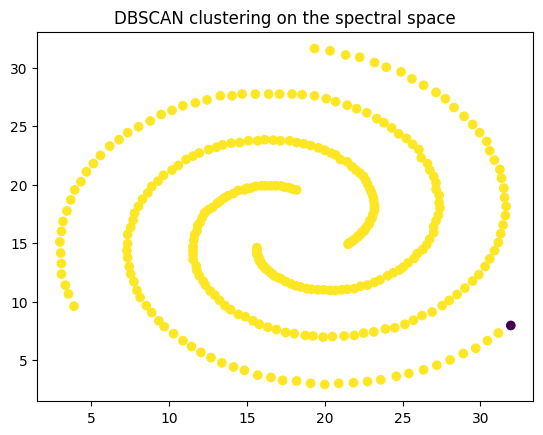

Silhouette score for DBSCAN clustering applied on the 6-dimensional points:0.19905506029506684
Adjusted rand score: -0.00012092545639447866


In [ ]:
dbscan = DBSCAN(eps = 0.15, min_samples=k)
labels_db_spec = dbscan.fit_predict(np.asarray(U_spirals_40))
print(f'Number of clusters found by DBSCAN on the spectral space: {len(np.unique(labels_db_spec))}')

plt.scatter(spirals.loc[:, 'x'], spirals.loc[:, 'y'], c = labels_db_spec, cmap = 'viridis')
plt.title('DBSCAN clustering on the spectral space')
plt.show()

silh_db_spec = silhouette_score(spirals, labels_db_spec)
adj_db = adjusted_rand_score(labels_db_spec, spirals['label'])
print(f'Silhouette score for DBSCAN clustering applied on the {M}-dimensional points:{silh_db_spec}')
print(f'Adjusted rand score: {adj_db}')

Tried multiple values for eps, but we get always more or less the same clusters.

Last test: we try a smaller value for k.

In [ ]:
k = 8
L_spiral_8, W_spiral_8, D_spiral_8 = compute_L_W_D(spirals, k)

# Compute the dimension of the Laplacian matrix
rank = np.linalg.matrix_rank(L_spiral_8.todense())

# Compute the dimension of the Laplacian null space, and therefore the number of null eigenvalues
null_eigs = L_spiral_8.shape[0] - rank

print(f'The number of null eigenvalues is {null_eigs}, that is also the number of connected components in the graph')

# Compute the eigenvalues and eigenvectors of the Laplacian matrix
eigenvalues, eigenvectors = np.linalg.eigh(L_spiral_8.todense())

print(f'The smallest eigenvalue of the Laplacian matrix are {eigenvalues[:20]}')

The number of null eigenvalues is 1, that is also the number of connected components in the graph
The smallest eigenvalue of the Laplacian matrix are [3.08697219e-16 2.99804715e-03 3.32093363e-03 1.19060592e-02
 2.14556625e-02 2.32516748e-02 4.93195331e-02 5.03613726e-02
 5.88108312e-02 9.86306192e-02 1.00946835e-01 1.30268542e-01
 1.70109126e-01 1.72828985e-01 1.85104096e-01 2.54060207e-01
 2.77741990e-01 2.96355332e-01 3.66132564e-01 3.78894772e-01]


In [ ]:
M = 3
U_spirals_8 = eigenvectors[:, :M]

print(f'Hence we define U_spirales_5 as the matrix of the first {M} eigenvectors of the Laplacian matrix')

Hence we define U_spirales_5 as the matrix of the first 3 eigenvectors of the Laplacian matrix


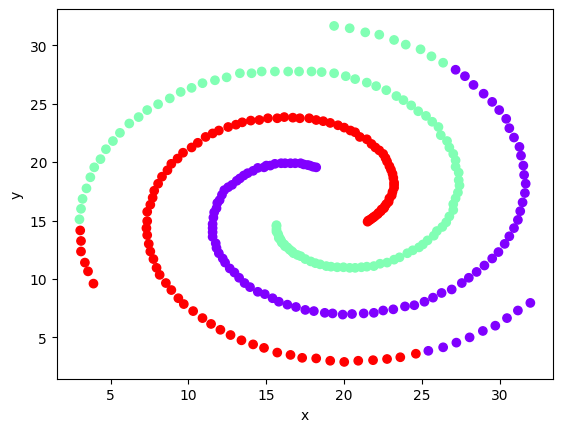

Silhouette score for KMeans clustering applied on the 3-dimensional points:0.012023879160214808
Adjusted rand score with the original labels: 0.7862289401393443


In [ ]:
k_kmeans = 3
kmeans = KMeans(n_clusters = k_kmeans, random_state = 42)
labels_km_spec = kmeans.fit_predict(np.asarray(U_spirals_8))

plt.scatter(spirals.loc[:, 'x'], spirals.loc[:, 'y'], c = labels_km_spec, cmap = 'rainbow')
# plt.title('KMeans clustering on the spectral space')
plt.xlabel('x')
plt.ylabel('y')
plt.show()

silh_km_spec = silhouette_score(spirals, labels_km_spec)
adj_km = adjusted_rand_score(labels_km_spec, spirals['label'])
print(f'Silhouette score for KMeans clustering applied on the {M}-dimensional points:{silh_km_spec}')
print(f'Adjusted rand score with the original labels: {adj_km}')